In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import torch, IPython, itertools, string
import random, time, warnings
import matplotlib.pyplot as plt
from matplotlib import animation

In [3]:
warnings.simplefilter('ignore')

In [4]:
class Point(torch.nn.Module):
    def __init__(self, linkage, name, at=None, on=None, anchored_at=None):
        super(Point, self).__init__()
        self.linkage = linkage
        self.name = name
        if at is not None:
            self.mode = 'at'
            self.type = 'free_point'
            self.parent = None
            self.r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
        elif on is not None:
            self.mode = 'on'
            self.type = 'co_point'
            self.parent = on
            if self.parent.__class__.__name__ is 'Point':
                self.r = self.parent.r
            elif self.parent.__class__.__name__ is 'Line':
                raise Exception()
        elif anchored_at is not None:
            self.mode = 'anchored_at'
            self.type = 'anchored_point'
            self.parent = None
            self.r = torch.tensor(anchored_at).to(torch.float)
        else:
            self.mode = None
            self.type = 'null_point'
            self.parent = None
            self.r = None
    
    def __repr__(self):
        if self.mode is 'at':
            return('Point_{}(at={})'.format(self.name, str(self.r.tolist())))
        elif self.mode is 'on':
            return('Point_{}(on={})'.format(self.name, str(self.parent)))
        elif self.mode is 'anchored_at':
            return('Point_{}(anchored_at={})'.format(self.name, str(self.r.tolist())))
        else:
            return('Point_{}(None)'.format(self.name))
    
    def constrain_on(self, parent):
        self.mode = 'on'
        self.type = 'co_point'
        self.parent = parent
        if self.parent.__class__.__name__ is 'Point':
            self.r = self.parent.r
        elif self.parent.__class__.__name__ is 'Line':
            raise Exception()

In [5]:
class Line(torch.nn.Module):
    def __init__(self, linkage, name, r1, r2):
        super(Line, self).__init__()
        self.linkage = linkage
        self.name = name
        self.target_length = None
        if r1.__class__.__name__ is 'Point':
            self.p1 = Point(self.linkage, '{}{}'.format(self.name, '1'), on=r1)
        else:
            self.p1 = Point(self.linkage, '{}{}'.format(self.name, '1'), at=r1)
        if r2.__class__.__name__ is 'Point':
            self.p2 = Point(self.linkage, '{}{}'.format(self.name, '2'), on=r2)
        else:
            self.p2 = Point(self.linkage, '{}{}'.format(self.name, '2'), at=r2)
        
    def __repr__(self):
        return('Line_{}(p1={}, p2={})'.format(self.name, str(self.p1), str(self.p2)))
    
    def length(self):
        L = (self.p2.r-self.p1.r).pow(2).sum().pow(0.5)
        return(L)
    
    def constrain_length(self, L):
        self.target_length = L
        self.linkage.update()

In [6]:
class Linkage():
    def __init__(self):       
        self.points = torch.nn.ModuleDict({})
        self.anchors = torch.nn.ModuleDict({})
        self.lines = torch.nn.ModuleDict({})
        self.names = {}
        for _type in ['point', 'anchor', 'line']:
            self.names[_type] = []
            letters = string.ascii_letters[-26:]
            if _type is 'line':
                letters = letters.lower()
            for n in range(3):
                for t in itertools.product(letters, repeat=n):
                    self.names[_type].append(''.join(t))
            self.names[_type] = iter(self.names[_type][1:])
        self.plot = LinkagePlot(self)
    
    def add_point_at(self, r):
        name = next(self.names['point'])
        self.points[name] = Point(self, name, at=r)
        
    def add_point_on(self, p):
        name = next(self.names['point'])
        self.points[name] = Point(self, name, on=p)
    
    def add_anchor_at(self, r):
        name = next(self.names['anchor'])
        self.anchors[name] = Point(self, name, anchored_at=r)
    
    def add_line(self, r1, r2):
        name = next(self.names['line'])
        self.lines[name] = Line(self, name, r1, r2)
        
    @property
    def N(self):
        N = 0
        N += len(self.points)
        N += len(self.anchors)
        N += 2*len(self.lines)
        return(N)
    
    @property
    def M(self):
        return(len(self.lines))
     
    def parameters(self):
        parameters = []
        for point in self.points.values():
            for param in point.parameters():
                parameters.append(param)
        for anchor in self.anchors.values():
            for param in anchor.parameters():
                parameters.append(param)
        for line in self.lines.values():
            for param in line.parameters():
                parameters.append(param)
        return(parameters)
        
    def xyz(self):
        xyz = torch.zeros((self.N, 3))
        n = 0
        for point in self.points.values():
            xyz[n] += point.r
            n += 1
        for anchor in self.anchors.values():
            xyz[n] += anchor.r
            n += 1
        for line in self.lines.values():
            xyz[n] += line.p1.r
            xyz[n+1] += line.p2.r
            n += 2
        return(xyz)
        
    def energy(self):
        E = 0.0
        for line in self.lines.values():
            if line.target_length is not None:
                E += (line.length()-line.target_length).abs()
        return(E)
            
    def update(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.05) #, momentum=0.99, dampening=0.99)
        for epoch in range(1000):
            #xyz = self.xyz()
            optimizer.zero_grad()
            E = self.energy()
            E.backward()
            optimizer.step()
            self.plot.E_list.append(E.item())
            if epoch % 100 == 0:
                self.plot.update()
                #print(epoch, E.item())
                time.sleep(0.1)

In [7]:
class LinkagePlot():
    def __init__(self, linkage):
        self.linkage = linkage
        self.origin = torch.tensor([0,0,0])
        self.E_list = [10000.0]
        
        # Set up figure and axis
        self.size = 5
        self.fig = plt.figure(figsize=(2*self.size,self.size))
        self.ax1 = self.fig.add_subplot(121, autoscale_on=False,
            xlim=(-self.size,self.size),
            ylim=(-self.size,self.size))
        self.ax2 = self.fig.add_subplot(122, autoscale_on=False,
            xlim=(0,1),
            ylim=(0,1))
        self.ax1.set_title('Configuration')
        self.ax2.set_title('log10(E)')
        
        # Plot origin and lines
        self.ax1.scatter(
            [self.origin[0]], [self.origin[1]],
            marker='o', s=20, c='red', alpha=1)    
        self.lines = {}
        for line_name in self.linkage.lines.keys():
            line, = self.ax1.plot([], [], '-', markersize=3, lw=1)
            self.lines[line_name] = line
        self.lnE_line, = self.ax2.plot([], [], 'b-', markersize=3, lw=1, label='log10(E)')
        time_template = ' t={:.0f}\n E={:.2f}\n T={:.5f}\n theta={:.0f}\n'
        self.time_text = self.ax1.text(0.05, 0.7, '', transform=self.ax1.transAxes)
        
    def update(self):
        #xyz = self.linkage.xyz()
        for line_name in self.linkage.lines.keys():
            if line_name not in self.lines.keys():
                line, = self.ax1.plot([], [], '-', markersize=3, lw=1)
                self.lines[line_name] = line
            line = self.linkage.lines[line_name]
            self.lines[line_name].set_data(
                [line.p1.r[0],line.p2.r[0]],
                [line.p1.r[1],line.p2.r[1]])
        self.lnE_line.set_xdata(torch.arange(0,len(self.E_list)))
        self.lnE_line.set_ydata(torch.log10(torch.tensor(self.E_list)))
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_xlim(0,len(self.E_list))
        self.ax2.set_ylim(-3,2)
        self.time_text.set_text('')
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


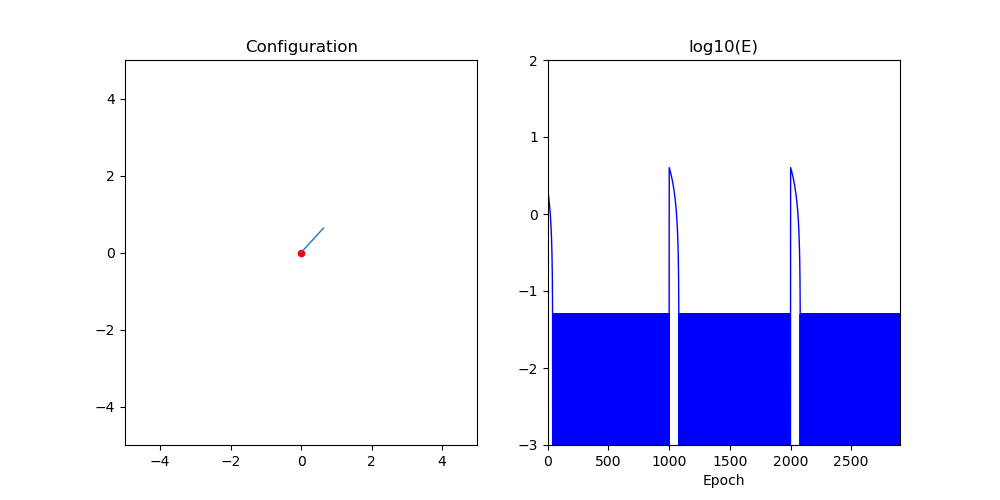

In [8]:
linkage = Linkage()

In [9]:
linkage.add_anchor_at([0,0,0])

In [10]:
linkage.add_point_at([2,2,2])

In [11]:
linkage.add_line(linkage.anchors['A'],[2,2,1])

In [12]:
list(linkage.parameters())

[Parameter containing:
 tensor([2., 2., 2.], requires_grad=True), Parameter containing:
 tensor([2., 2., 1.], requires_grad=True)]

In [13]:
linkage.lines['a'].constrain_length(1)

In [14]:
linkage.lines['a'].constrain_length(5)

In [15]:
linkage.lines['a'].constrain_length(1)